In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
from help_functions import fpl_functions as fpl
pd.options.mode.chained_assignment = None
sns.set_theme()

In [3]:
GAMEWEEKS_PLAYED = 6

In [4]:
df = pd.read_excel('../data/players_Gameweek_{}.xlsx'.format(GAMEWEEKS_PLAYED))
fixtures = pd.read_excel('../data/fixtures.xlsx')
my_team = pd.read_excel('../data/my_team_Gameweek_{}.xlsx'.format(GAMEWEEKS_PLAYED))

In [5]:
my_team

,Players,multiplier,is_captain,is_vice_captain
0,Sels,1,False,False
1,Bednarek,1,False,False
2,Alexander-Arnold,1,False,False
3,Mykolenko,1,False,False
4,Mbeumo,1,False,False
5,McNeil,1,False,False
6,Saka,1,False,False
7,Rogers,1,False,False
8,M.Salah,1,False,True
9,Haaland,2,True,False


In [6]:
df.loc[df['position'] == 'Goalkeeper'].groupby('team')['expected_goals_conceded'].sum().sort_values()

team
Liverpool          4.32
Man City           5.21
Nott'm Forest      5.31
Bournemouth        5.41
Spurs              6.08
Aston Villa        6.37
Fulham             6.59
Chelsea            6.87
Crystal Palace     9.07
Wolves             9.32
Newcastle          9.45
Arsenal            9.71
Everton            9.81
Brighton          10.00
West Ham          10.48
Man Utd           10.98
Southampton       11.22
Ipswich           11.91
Brentford         12.07
Leicester         12.81
Name: expected_goals_conceded, dtype: float64

In [7]:
df.drop(df[df['status'].isin(['d', 'i', 's', 'u'])].index, inplace=True)
df = df.drop(df[df['minutes'] == 0].index)

df['now_cost'] = df['now_cost']/10

#create points per million (cost) column (ppm)
df['ppm'] = round(df['total_points']/df['now_cost'], 2)

df['goal_involvements'] = df['goals_scored'] + df['assists']
#create expected goals and goal involvements vs actual goals and goal involvements columns
df['g_vs_xg'] = df['goals_scored'] - df['expected_goals']
df['gi_vs_xgi'] = df['goal_involvements'] - df['expected_goal_involvements']

df['points_per_minute'] = df['total_points']/df['minutes']

df['gc_vs_xgc'] = df['goals_conceded'] - df['expected_goals_conceded']

df['percent_of_season_played'] = np.round(df['minutes']/(GAMEWEEKS_PLAYED*90) * 100, 2)
#drop players who've played less than half the season up until now
df = df.drop(df[df['percent_of_season_played'] < 50].index)

#expected goal involvements per million; could this be a good way to determine which players are "undervalued"?
df['xgi_pm'] = round(df['expected_goal_involvements']/df['now_cost'], 2)
df['xg_pm'] = round(df['expected_goals']/df['now_cost'], 2)
df['xa_pm'] = round(df['expected_assists']/df['now_cost'], 2)

In [8]:
fixtures_going_forward = fixtures.loc[fixtures['Gameweek'] > GAMEWEEKS_PLAYED]

df['next_match'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures, x, GAMEWEEKS_PLAYED+1)[['opponent', 'h_or_a']].iloc[-1]))
df['next_5_FDRs'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures_going_forward, x, GAMEWEEKS_PLAYED+5)['FDR']))
#df['past_3_FDRs'] = df['team'].apply(lambda x: list(fpl.fixtures_by_team(fixtures, x, GAMEWEEKS_PLAYED)['FDR']))
df['next_5_avg_FDRs'] = df['next_5_FDRs'].apply(lambda x: np.round(np.mean(x), 2))
#df['past_3_avg_FDRs'] = df['past_3_FDRs'].apply(lambda x: np.mean(x))

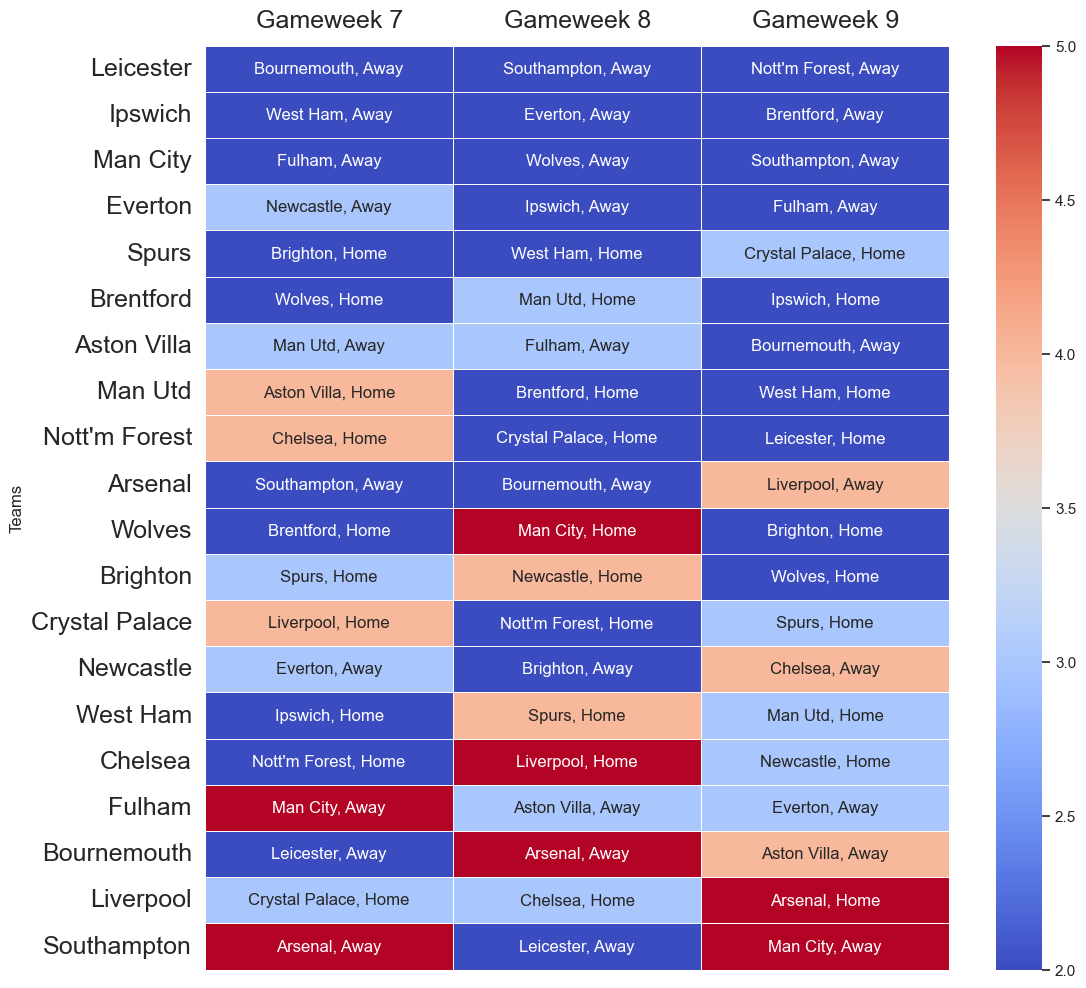

In [9]:
pl_teams = fixtures['team_h'].unique()
fixture_matrix_fdr = pd.DataFrame({'Teams': pl_teams})
fixture_matrix_fdr['next_5_fdr'] = fixture_matrix_fdr['Teams'].apply(lambda x: fpl.fixtures_by_team(fixtures_going_forward, x, GAMEWEEKS_PLAYED+3)['FDR'].mean())
fixture_matrix_fdr.sort_values(by='next_5_fdr', ascending=True, inplace=True)
fixture_matrix_fdr.drop('next_5_fdr', axis=1, inplace=True)

fixture_matrix_matches = fixture_matrix_fdr.copy()

for i in range(GAMEWEEKS_PLAYED, GAMEWEEKS_PLAYED+3):
    gw_fix = []
    for team in fixture_matrix_fdr['Teams'].values:
        fdr = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['FDR'].values[i-GAMEWEEKS_PLAYED]
        gw_fix.append(fdr)
    fixture_matrix_fdr['Gameweek {}'.format(i+1)] = gw_fix

for i in range(GAMEWEEKS_PLAYED, GAMEWEEKS_PLAYED+3):
    gw_fix = []
    for team in fixture_matrix_fdr['Teams'].values:
        opponent = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['opponent'].values[i-GAMEWEEKS_PLAYED]
        h_or_a = fpl.fixtures_by_team(fixtures_going_forward, team, GAMEWEEKS_PLAYED+5)['h_or_a'].values[-1]
        gw_fix.append('{}, {}'.format(opponent, h_or_a))
    fixture_matrix_matches['Gameweek {}'.format(i+1)] = gw_fix

fig, ax = plt.subplots(figsize=(12,12)) 
ax = sns.heatmap(fixture_matrix_fdr.set_index('Teams'), annot=fixture_matrix_matches.set_index('Teams'), fmt='', linewidth=.5, cmap='coolwarm')
plt.tick_params(axis='both', which='major', labelsize=18, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.show()

In [10]:
first_four_fixtures = pd.DataFrame()
for i in pl_teams:
    temp = fpl.fixtures_by_team(fixtures, i, GAMEWEEKS_PLAYED)
    first_four_fixtures = pd.concat([first_four_fixtures, temp])

first_4_fdrs = pd.DataFrame(first_four_fixtures.groupby('selected_team')['FDR'].sum().astype(int).sort_values(ascending=False)).reset_index()
first_4_fdrs.rename(columns={'selected_team': 'team'}, inplace=True)

#this won't count own goals scored
first_4_gi_xgi = pd.DataFrame(df.groupby('team')[['goals_scored', 'expected_goals', 'g_vs_xg']].sum().sort_values(by='expected_goals', ascending=False)).reset_index()

first_4_gi_xgi

,team,goals_scored,expected_goals,g_vs_xg
0,Liverpool,11,11.07,-0.07
1,Spurs,8,10.55,-2.55
2,Chelsea,13,10.33,2.67
3,Man Utd,5,10.12,-5.12
4,Man City,12,10.08,1.92
5,Arsenal,10,9.26,0.74
6,Bournemouth,6,7.67,-1.67
7,Nott'm Forest,5,6.27,-1.27
8,Fulham,4,6.27,-2.27
9,West Ham,4,5.95,-1.95


In [11]:
#join gi vs xgi and fdr tables for first 3 games
first_4_games_table = first_4_gi_xgi.merge(first_4_fdrs, on='team', how='left')
first_4_games_table['FDR'] = first_4_games_table['FDR'] - np.median(first_4_games_table['FDR'].unique())

first_4_games_table

,team,goals_scored,expected_goals,g_vs_xg,FDR
0,Liverpool,11,11.07,-0.07,-4.0
1,Spurs,8,10.55,-2.55,1.0
2,Chelsea,13,10.33,2.67,-2.0
3,Man Utd,5,10.12,-5.12,-1.0
4,Man City,12,10.08,1.92,2.0
5,Arsenal,10,9.26,0.74,2.0
6,Bournemouth,6,7.67,-1.67,1.0
7,Nott'm Forest,5,6.27,-1.27,-2.0
8,Fulham,4,6.27,-2.27,-3.0
9,West Ham,4,5.95,-1.95,2.0


In [12]:
fpl.top_players(df, 'Goalkeeper', 'expected_goals_conceded', True, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,clean_sheets,saves,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
372,A.Becker,Liverpool,5.5,9.5,99,83.33,4.55,"[Crystal Palace, Away]",3.2,3,11,2,3.24,-1.24,25
94,Arrizabalaga,Bournemouth,4.5,0.8,33,50.00,2.00,"[Leicester, Away]",3.6,0,17,6,4.63,1.37,9
409,Ederson M.,Man City,5.5,8.4,75,100.00,3.82,"[Fulham, Home]",2.0,1,14,6,5.21,0.79,21
514,Sels,Nott'm Forest,4.5,2.9,74,100.00,5.11,"[Chelsea, Away]",2.6,2,12,5,5.31,-0.31,23
592,Vicario,Spurs,5.0,3.6,106,100.00,4.00,"[Brighton, Away]",2.4,2,14,5,6.08,-1.08,20
51,Martinez,Aston Villa,5.0,12.9,51,100.00,2.20,"[Man Utd, Home]",3.4,0,13,9,6.37,2.63,11
625,Johnstone,Wolves,4.4,0.5,29,66.67,1.82,"[Brentford, Away]",2.6,0,12,8,6.52,1.48,8
289,Leno,Fulham,5.0,2.4,83,100.00,3.60,"[Man City, Away]",3.2,1,17,5,6.59,-1.59,18
11,Raya,Arsenal,5.6,31.2,118,100.00,6.07,"[Southampton, Home]",3.2,3,24,5,6.80,-1.80,34
208,Sánchez,Chelsea,4.7,11.6,117,100.00,6.81,"[Nott'm Forest, Home]",3.6,2,25,7,6.87,0.13,32


In [13]:
fpl.top_players(df, 'Goalkeeper', 'expected_goals_conceded', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,clean_sheets,saves,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
350,Hermansen,Leicester,4.5,0.7,74,100.00,3.33,"[Bournemouth, Home]",2.2,0,31,12,12.81,-0.81,15
104,Flekken,Brentford,4.5,12.2,96,100.00,3.78,"[Wolves, Home]",2.4,0,30,10,12.07,-2.07,17
448,Onana,Man Utd,5.0,5.9,119,100.00,6.60,"[Aston Villa, Away]",2.6,3,18,8,10.98,-2.98,33
266,Pickford,Everton,4.8,8.1,25,100.00,2.08,"[Newcastle, Home]",2.2,0,17,15,9.81,5.19,10
332,Muric,Ipswich,4.4,1.0,45,83.33,3.86,"[West Ham, Away]",2.4,1,13,8,9.26,-1.26,17
601,Areola,West Ham,4.5,7.3,51,91.67,3.11,"[Ipswich, Home]",2.6,1,14,9,9.19,-0.19,14
226,Henderson,Crystal Palace,4.5,11.4,61,100.00,4.00,"[Liverpool, Home]",2.6,1,19,9,9.07,-0.07,18
525,Ramsdale,Southampton,4.4,2.1,37,66.67,2.27,"[Arsenal, Away]",3.2,0,19,10,8.52,1.48,10
164,Verbruggen,Brighton,4.5,2.0,47,66.67,2.22,"[Spurs, Home]",3.8,1,11,7,8.12,-1.12,10
208,Sánchez,Chelsea,4.7,11.6,117,100.00,6.81,"[Nott'm Forest, Home]",3.6,2,25,7,6.87,0.13,32


In [14]:
fpl.top_players(df, 'Defender', 'expected_goal_involvements_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
373,Alexander-Arnold,Liverpool,7.1,31.7,122,91.11,4.65,"[Crystal Palace, Away]",3.2,0,1,1,2.37,-1.37,0.43,4,2,3.75,-1.75,33
454,De Ligt,Man Utd,5.0,4.9,83,65.56,4.80,"[Aston Villa, Away]",2.6,1,0,1,1.13,-0.13,0.28,2,7,8.68,-1.68,24
396,Robertson,Liverpool,6.0,7.1,131,92.96,4.50,"[Crystal Palace, Away]",3.2,0,0,0,1.44,-1.44,0.26,4,2,4.07,-2.07,27
2,Gabriel,Arsenal,6.2,25.4,126,100.00,5.97,"[Southampton, Home]",3.2,2,0,2,1.38,0.62,0.23,3,5,6.80,-1.80,37
626,Aït-Nouri,Wolves,4.4,2.0,27,87.78,2.95,"[Brentford, Away]",2.6,1,1,2,1.20,0.80,0.23,0,15,7.94,7.06,13
521,Milenković,Nott'm Forest,4.5,0.4,63,83.33,3.78,"[Chelsea, Away]",2.6,0,0,0,1.14,-1.14,0.22,2,4,4.09,-0.09,17
313,Davis,Ipswich,4.5,2.1,77,100.00,4.00,"[West Ham, Away]",2.4,0,1,1,1.32,-0.32,0.22,1,10,11.91,-1.91,18
580,Pedro Porro,Spurs,5.5,29.6,116,99.44,4.55,"[Brighton, Away]",2.4,1,0,1,1.30,-0.30,0.22,2,5,6.02,-1.02,25
553,Sugawara,Southampton,4.5,0.3,62,88.15,2.89,"[Arsenal, Away]",3.2,1,0,1,1.09,-0.09,0.21,0,12,10.91,1.09,13
583,Romero,Spurs,5.1,10.0,130,100.00,5.29,"[Brighton, Away]",2.4,1,0,1,1.24,-0.24,0.21,2,5,6.08,-1.08,27


In [32]:
fpl.top_players(df, 'Defender', 'expected_goals_conceded', True, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
508,N.Williams,Nott'm Forest,4.5,0.5,43,61.30,2.44,"[Chelsea, Away]",2.6,0,0,0,0.61,-0.61,0.17,1,2,2.75,-0.75,11
373,Alexander-Arnold,Liverpool,7.1,31.7,122,91.11,4.65,"[Crystal Palace, Away]",3.2,0,1,1,2.37,-1.37,0.43,4,2,3.75,-1.75,33
286,Diop,Fulham,4.5,0.3,30,51.48,1.78,"[Man City, Away]",3.2,0,0,0,0.19,-0.19,0.07,0,3,3.81,-0.81,8
247,Lacroix,Crystal Palace,4.5,0.1,44,50.00,2.22,"[Liverpool, Home]",2.6,0,1,1,0.37,0.63,0.12,1,4,3.82,0.18,10
387,Konaté,Liverpool,5.2,10.0,131,88.70,5.96,"[Crystal Palace, Away]",3.2,1,1,2,0.48,1.52,0.10,3,2,3.83,-1.83,31
194,Gusto,Chelsea,4.9,1.6,22,63.52,0.82,"[Nott'm Forest, Home]",3.6,0,0,0,0.14,-0.14,0.04,0,7,3.93,3.07,4
396,Robertson,Liverpool,6.0,7.1,131,92.96,4.50,"[Crystal Palace, Away]",3.2,0,0,0,1.44,-1.44,0.26,4,2,4.07,-2.07,27
521,Milenković,Nott'm Forest,4.5,0.4,63,83.33,3.78,"[Chelsea, Away]",2.6,0,0,0,1.14,-1.14,0.22,2,4,4.09,-0.09,17
412,Gvardiol,Man City,5.9,22.4,106,91.11,3.73,"[Fulham, Home]",2.0,1,0,1,1.05,-0.05,0.19,1,5,4.20,0.80,22
422,Rúben,Man City,5.5,3.9,52,84.44,1.64,"[Fulham, Home]",2.0,0,0,0,0.94,-0.94,0.19,1,5,4.29,0.71,9


In [15]:
fpl.top_players_by_cost(df, 'Defender', 4.5, 'expected_goals_conceded', 10, asc=True)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
508,N.Williams,Nott'm Forest,4.5,0.5,43,61.30,2.44,"[Chelsea, Away]",2.6,0,0,0,0.61,-0.61,0.17,1,2,2.75,-0.75,11
286,Diop,Fulham,4.5,0.3,30,51.48,1.78,"[Man City, Away]",3.2,0,0,0,0.19,-0.19,0.07,0,3,3.81,-0.81,8
247,Lacroix,Crystal Palace,4.5,0.1,44,50.00,2.22,"[Liverpool, Home]",2.6,0,1,1,0.37,0.63,0.12,1,4,3.82,0.18,10
521,Milenković,Nott'm Forest,4.5,0.4,63,83.33,3.78,"[Chelsea, Away]",2.6,0,0,0,1.14,-1.14,0.22,2,4,4.09,-0.09,17
635,Dawson,Wolves,4.4,0.2,19,55.37,1.36,"[Brentford, Away]",2.6,0,0,0,0.11,-0.11,0.03,0,7,4.30,2.70,6
590,Van de Ven,Spurs,4.5,8.8,103,81.48,5.33,"[Brighton, Away]",2.4,0,2,2,0.77,1.23,0.16,2,3,4.32,-1.32,24
493,Aina,Nott'm Forest,4.5,6.0,84,93.15,4.89,"[Chelsea, Away]",2.6,0,0,0,0.57,-0.57,0.11,2,4,4.64,-0.64,22
279,Andersen,Fulham,4.4,9.4,61,66.67,2.73,"[Man City, Away]",3.2,0,0,0,0.23,-0.23,0.06,1,4,4.69,-0.69,12
163,Veltman,Brighton,4.5,3.5,85,79.81,4.44,"[Spurs, Home]",3.8,0,0,0,0.54,-0.54,0.11,2,4,4.89,-0.89,20
467,Hall,Newcastle,4.3,2.1,63,62.41,2.79,"[Everton, Away]",3.2,0,0,0,0.29,-0.29,0.08,1,3,4.93,-1.93,12


In [27]:
fpl.top_players_by_cost(df, 'Defender', 4.5, 'ppm', 10, asc=False)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,assists,goal_involvements,expected_goal_involvements,gi_vs_xgi,expected_goal_involvements_per_90,clean_sheets,goals_conceded,expected_goals_conceded,gc_vs_xgc,total_points
590,Van de Ven,Spurs,4.5,8.8,103,81.48,5.33,"[Brighton, Away]",2.4,0,2,2,0.77,1.23,0.16,2,3,4.32,-1.32,24
493,Aina,Nott'm Forest,4.5,6.0,84,93.15,4.89,"[Chelsea, Away]",2.6,0,0,0,0.57,-0.57,0.11,2,4,4.64,-0.64,22
163,Veltman,Brighton,4.5,3.5,85,79.81,4.44,"[Spurs, Home]",3.8,0,0,0,0.54,-0.54,0.11,2,4,4.89,-0.89,20
225,Guéhi,Crystal Palace,4.4,6.0,88,100.00,4.32,"[Liverpool, Home]",2.6,1,0,1,0.38,0.62,0.06,1,9,9.07,-0.07,19
507,Murillo,Nott'm Forest,4.5,0.8,91,100.00,4.22,"[Chelsea, Away]",2.6,0,0,0,0.28,-0.28,0.05,2,5,5.31,-0.31,19
352,Justin,Leicester,4.5,0.9,78,100.00,4.22,"[Bournemouth, Home]",2.2,2,0,2,0.38,1.62,0.07,0,12,12.81,-0.81,19
445,Martinez,Man Utd,4.5,4.8,83,97.41,4.22,"[Aston Villa, Away]",2.6,0,0,0,1.05,-1.05,0.18,3,8,10.98,-2.98,19
313,Davis,Ipswich,4.5,2.1,77,100.00,4.00,"[West Ham, Away]",2.4,0,1,1,1.32,-0.32,0.22,1,10,11.91,-1.91,18
185,Colwill,Chelsea,4.5,3.4,84,100.00,3.78,"[Nott'm Forest, Home]",3.6,0,0,0,0.66,-0.66,0.11,2,7,6.87,0.13,17
521,Milenković,Nott'm Forest,4.5,0.4,63,83.33,3.78,"[Chelsea, Away]",2.6,0,0,0,1.14,-1.14,0.22,2,4,4.09,-0.09,17


In [17]:
fpl.top_players(df, 'Midfielder', 'expected_goals_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
205,Palmer,Chelsea,10.7,46.0,247,93.52,5.70,"[Nott'm Forest, Home]",3.6,6,...,3.68,1.69,5.37,4.63,0.34,0.16,0.50,0.66,0.96,61
437,Garnacho,Man Utd,6.3,9.1,43,59.07,2.70,"[Aston Villa, Away]",2.6,1,...,2.31,0.37,2.68,-0.68,0.37,0.06,0.43,0.65,0.75,17
389,M.Salah,Liverpool,12.7,41.5,204,98.52,4.65,"[Crystal Palace, Away]",3.2,4,...,3.76,1.38,5.14,2.86,0.30,0.11,0.40,0.64,0.87,59
388,Luis Díaz,Liverpool,8.1,36.7,180,79.44,6.54,"[Crystal Palace, Away]",3.2,5,...,2.75,0.73,3.48,2.52,0.34,0.09,0.43,0.58,0.73,53
576,Johnson,Spurs,6.4,2.0,94,78.33,4.53,"[Brighton, Away]",2.4,2,...,2.40,0.45,2.85,1.15,0.37,0.07,0.45,0.51,0.61,29
378,Diogo J.,Liverpool,7.5,8.8,64,69.07,3.47,"[Crystal Palace, Away]",3.2,1,...,1.91,0.26,2.17,1.83,0.25,0.03,0.29,0.46,0.52,26
616,Souček,West Ham,5.0,2.8,82,67.96,5.00,"[Ipswich, Home]",2.6,2,...,1.73,0.51,2.24,0.76,0.35,0.10,0.45,0.42,0.55,25
18,Trossard,Arsenal,6.9,2.3,79,58.15,3.19,"[Southampton, Home]",3.2,2,...,1.45,0.25,1.70,1.30,0.21,0.04,0.25,0.42,0.49,22
200,Madueke,Chelsea,6.5,9.7,110,71.67,5.08,"[Nott'm Forest, Home]",3.6,3,...,1.63,0.16,1.79,2.21,0.25,0.02,0.28,0.38,0.42,33
91,Tavernier,Bournemouth,5.5,0.4,96,94.63,4.00,"[Leicester, Away]",3.6,1,...,2.08,0.82,2.90,-0.90,0.38,0.15,0.53,0.37,0.51,22


In [18]:
fpl.top_players(df, 'Midfielder', 'expected_goal_involvements', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
205,Palmer,Chelsea,10.7,46.0,247,93.52,5.70,"[Nott'm Forest, Home]",3.6,6,...,3.68,1.69,5.37,4.63,0.34,0.16,0.50,0.66,0.96,61
389,M.Salah,Liverpool,12.7,41.5,204,98.52,4.65,"[Crystal Palace, Away]",3.2,4,...,3.76,1.38,5.14,2.86,0.30,0.11,0.40,0.64,0.87,59
579,Maddison,Spurs,7.5,4.8,145,88.70,3.87,"[Brighton, Away]",2.4,1,...,1.87,2.94,4.81,-0.81,0.25,0.39,0.64,0.35,0.90,29
13,Saka,Arsenal,10.1,33.1,165,88.15,3.76,"[Southampton, Home]",3.2,1,...,1.69,2.22,3.91,2.09,0.17,0.22,0.39,0.32,0.74,38
112,Mbeumo,Brentford,7.4,23.1,175,99.81,5.81,"[Wolves, Home]",2.4,5,...,2.01,1.69,3.70,1.30,0.27,0.23,0.50,0.34,0.62,43
388,Luis Díaz,Liverpool,8.1,36.7,180,79.44,6.54,"[Crystal Palace, Away]",3.2,5,...,2.75,0.73,3.48,2.52,0.34,0.09,0.43,0.58,0.73,53
262,McNeil,Everton,5.6,5.7,179,98.52,6.96,"[Newcastle, Home]",2.2,3,...,0.49,2.97,3.45,1.55,0.09,0.53,0.62,0.08,0.58,39
87,Semenyo,Bournemouth,5.7,10.6,105,95.74,5.09,"[Leicester, Away]",3.6,3,...,1.86,1.44,3.30,0.70,0.33,0.25,0.58,0.32,0.57,29
431,B.Fernandes,Man Utd,8.2,7.6,66,88.70,1.59,"[Aston Villa, Away]",2.6,0,...,1.86,1.34,3.20,-2.20,0.23,0.16,0.39,0.35,0.60,13
466,Gordon,Newcastle,7.3,11.0,112,94.26,3.84,"[Everton, Away]",3.2,2,...,2.01,1.07,3.08,-1.08,0.28,0.15,0.42,0.36,0.55,28


In [19]:
fpl.top_players(df, 'Midfielder', 'expected_goal_involvements_per_90', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
205,Palmer,Chelsea,10.7,46.0,247,93.52,5.70,"[Nott'm Forest, Home]",3.6,6,...,3.68,1.69,5.37,4.63,0.34,0.16,0.50,0.66,0.96,61
579,Maddison,Spurs,7.5,4.8,145,88.70,3.87,"[Brighton, Away]",2.4,1,...,1.87,2.94,4.81,-0.81,0.25,0.39,0.64,0.35,0.90,29
389,M.Salah,Liverpool,12.7,41.5,204,98.52,4.65,"[Crystal Palace, Away]",3.2,4,...,3.76,1.38,5.14,2.86,0.30,0.11,0.40,0.64,0.87,59
437,Garnacho,Man Utd,6.3,9.1,43,59.07,2.70,"[Aston Villa, Away]",2.6,1,...,2.31,0.37,2.68,-0.68,0.37,0.06,0.43,0.65,0.75,17
13,Saka,Arsenal,10.1,33.1,165,88.15,3.76,"[Southampton, Home]",3.2,1,...,1.69,2.22,3.91,2.09,0.17,0.22,0.39,0.32,0.74,38
388,Luis Díaz,Liverpool,8.1,36.7,180,79.44,6.54,"[Crystal Palace, Away]",3.2,5,...,2.75,0.73,3.48,2.52,0.34,0.09,0.43,0.58,0.73,53
112,Mbeumo,Brentford,7.4,23.1,175,99.81,5.81,"[Wolves, Home]",2.4,5,...,2.01,1.69,3.70,1.30,0.27,0.23,0.50,0.34,0.62,43
576,Johnson,Spurs,6.4,2.0,94,78.33,4.53,"[Brighton, Away]",2.4,2,...,2.40,0.45,2.85,1.15,0.37,0.07,0.45,0.51,0.61,29
431,B.Fernandes,Man Utd,8.2,7.6,66,88.70,1.59,"[Aston Villa, Away]",2.6,0,...,1.86,1.34,3.20,-2.20,0.23,0.16,0.39,0.35,0.60,13
262,McNeil,Everton,5.6,5.7,179,98.52,6.96,"[Newcastle, Home]",2.2,3,...,0.49,2.97,3.45,1.55,0.09,0.53,0.62,0.08,0.58,39


In [20]:
fpl.top_players(df, 'Midfielder', 'xgi_pm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
579,Maddison,Spurs,7.5,4.8,145,88.70,3.87,"[Brighton, Away]",2.4,1,...,1.87,2.94,4.81,-0.81,0.25,0.39,0.64,0.35,0.90,29
262,McNeil,Everton,5.6,5.7,179,98.52,6.96,"[Newcastle, Home]",2.2,3,...,0.49,2.97,3.45,1.55,0.09,0.53,0.62,0.08,0.58,39
87,Semenyo,Bournemouth,5.7,10.6,105,95.74,5.09,"[Leicester, Away]",3.6,3,...,1.86,1.44,3.30,0.70,0.33,0.25,0.58,0.32,0.57,29
91,Tavernier,Bournemouth,5.5,0.4,96,94.63,4.00,"[Leicester, Away]",3.6,1,...,2.08,0.82,2.90,-0.90,0.38,0.15,0.53,0.37,0.51,22
280,Adama,Fulham,5.1,3.8,111,86.30,5.10,"[Man City, Away]",3.2,1,...,1.16,1.43,2.59,0.41,0.23,0.28,0.51,0.22,0.50,26
112,Mbeumo,Brentford,7.4,23.1,175,99.81,5.81,"[Wolves, Home]",2.4,5,...,2.01,1.69,3.70,1.30,0.27,0.23,0.50,0.34,0.62,43
205,Palmer,Chelsea,10.7,46.0,247,93.52,5.70,"[Nott'm Forest, Home]",3.6,6,...,3.68,1.69,5.37,4.63,0.34,0.16,0.50,0.66,0.96,61
616,Souček,West Ham,5.0,2.8,82,67.96,5.00,"[Ipswich, Home]",2.6,2,...,1.73,0.51,2.24,0.76,0.35,0.10,0.45,0.42,0.55,25
576,Johnson,Spurs,6.4,2.0,94,78.33,4.53,"[Brighton, Away]",2.4,2,...,2.40,0.45,2.85,1.15,0.37,0.07,0.45,0.51,0.61,29
224,Eze,Crystal Palace,6.8,18.0,99,100.00,3.09,"[Liverpool, Home]",2.6,1,...,2.22,0.84,3.06,-2.06,0.33,0.12,0.45,0.37,0.51,21


In [21]:
fpl.top_players(df, 'Forward', 'expected_goal_involvements', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
413,Haaland,Man City,15.3,73.1,307,99.81,4.25,"[Fulham, Home]",2.0,10,...,6.14,0.28,6.42,3.58,0.40,0.02,0.42,1.03,1.08,65
203,N.Jackson,Chelsea,7.9,17.5,161,81.67,5.06,"[Nott'm Forest, Home]",3.6,4,...,4.42,0.20,4.62,2.38,0.56,0.03,0.58,0.90,0.94,40
62,Watkins,Aston Villa,9.1,29.0,134,81.67,4.29,"[Man Utd, Home]",3.4,4,...,3.50,0.27,3.77,2.23,0.38,0.03,0.41,0.71,0.77,39
562,Solanke,Spurs,7.6,10.1,72,66.11,2.11,"[Brighton, Away]",2.4,2,...,3.45,0.26,3.71,-1.71,0.45,0.03,0.49,0.87,0.94,16
3,Havertz,Arsenal,8.2,19.4,122,100.00,3.90,"[Southampton, Home]",3.2,3,...,3.52,0.16,3.68,0.32,0.43,0.02,0.45,0.59,0.62,32
452,Zirkzee,Man Utd,6.9,2.7,57,65.56,2.17,"[Aston Villa, Away]",2.6,1,...,2.44,0.31,2.75,-1.75,0.35,0.04,0.40,0.62,0.70,15
98,Evanilson,Bournemouth,5.9,0.7,50,65.19,2.54,"[Leicester, Away]",3.6,1,...,2.34,0.39,2.73,-1.73,0.40,0.07,0.46,0.60,0.70,15
166,Welbeck,Brighton,5.8,19.7,119,93.70,5.69,"[Spurs, Home]",3.8,3,...,2.37,0.27,2.64,1.36,0.41,0.05,0.46,0.42,0.47,33
517,Wood,Nott'm Forest,6.2,11.0,105,88.15,5.00,"[Chelsea, Away]",2.6,3,...,2.34,0.15,2.49,0.51,0.38,0.02,0.40,0.44,0.47,31
634,Cunha,Wolves,6.5,2.3,115,85.19,3.23,"[Brentford, Away]",2.6,2,...,1.49,0.81,2.30,-0.30,0.23,0.12,0.35,0.29,0.45,21


In [22]:
fpl.top_players(df, 'Forward', 'bps', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
413,Haaland,Man City,15.3,73.1,307,99.81,4.25,"[Fulham, Home]",2.0,10,...,6.14,0.28,6.42,3.58,0.40,0.02,0.42,1.03,1.08,65
203,N.Jackson,Chelsea,7.9,17.5,161,81.67,5.06,"[Nott'm Forest, Home]",3.6,4,...,4.42,0.20,4.62,2.38,0.56,0.03,0.58,0.90,0.94,40
62,Watkins,Aston Villa,9.1,29.0,134,81.67,4.29,"[Man Utd, Home]",3.4,4,...,3.50,0.27,3.77,2.23,0.38,0.03,0.41,0.71,0.77,39
3,Havertz,Arsenal,8.2,19.4,122,100.00,3.90,"[Southampton, Home]",3.2,3,...,3.52,0.16,3.68,0.32,0.43,0.02,0.45,0.59,0.62,32
166,Welbeck,Brighton,5.8,19.7,119,93.70,5.69,"[Spurs, Home]",3.8,3,...,2.37,0.27,2.64,1.36,0.41,0.05,0.46,0.42,0.47,33
634,Cunha,Wolves,6.5,2.3,115,85.19,3.23,"[Brentford, Away]",2.6,2,...,1.49,0.81,2.30,-0.30,0.23,0.12,0.35,0.29,0.45,21
517,Wood,Nott'm Forest,6.2,11.0,105,88.15,5.00,"[Chelsea, Away]",2.6,3,...,2.34,0.15,2.49,0.51,0.38,0.02,0.40,0.44,0.47,31
314,Delap,Ipswich,5.6,2.8,93,84.26,4.46,"[West Ham, Away]",2.4,3,...,1.04,0.04,1.08,1.92,0.19,0.01,0.19,0.21,0.22,25
363,Vardy,Leicester,5.7,11.4,81,92.59,3.86,"[Bournemouth, Home]",2.2,2,...,1.44,0.09,1.53,0.47,0.25,0.02,0.27,0.26,0.28,22
264,Ndiaye,Everton,5.4,0.9,76,72.59,2.96,"[Newcastle, Home]",2.2,1,...,0.51,0.18,0.69,0.31,0.09,0.03,0.13,0.12,0.16,16


In [23]:
fpl.top_players(df, 'Forward', 'xg_pm', False, 10)

,web_name,team,now_cost,selected_by_percent,bps,percent_of_season_played,ppm,next_match,next_5_avg_FDRs,goals_scored,...,expected_goals,expected_assists,expected_goal_involvements,gi_vs_xgi,xg_pm,xa_pm,xgi_pm,expected_goals_per_90,expected_goal_involvements_per_90,total_points
203,N.Jackson,Chelsea,7.9,17.5,161,81.67,5.06,"[Nott'm Forest, Home]",3.6,4,...,4.42,0.20,4.62,2.38,0.56,0.03,0.58,0.90,0.94,40
562,Solanke,Spurs,7.6,10.1,72,66.11,2.11,"[Brighton, Away]",2.4,2,...,3.45,0.26,3.71,-1.71,0.45,0.03,0.49,0.87,0.94,16
3,Havertz,Arsenal,8.2,19.4,122,100.00,3.90,"[Southampton, Home]",3.2,3,...,3.52,0.16,3.68,0.32,0.43,0.02,0.45,0.59,0.62,32
166,Welbeck,Brighton,5.8,19.7,119,93.70,5.69,"[Spurs, Home]",3.8,3,...,2.37,0.27,2.64,1.36,0.41,0.05,0.46,0.42,0.47,33
98,Evanilson,Bournemouth,5.9,0.7,50,65.19,2.54,"[Leicester, Away]",3.6,1,...,2.34,0.39,2.73,-1.73,0.40,0.07,0.46,0.60,0.70,15
413,Haaland,Man City,15.3,73.1,307,99.81,4.25,"[Fulham, Home]",2.0,10,...,6.14,0.28,6.42,3.58,0.40,0.02,0.42,1.03,1.08,65
62,Watkins,Aston Villa,9.1,29.0,134,81.67,4.29,"[Man Utd, Home]",3.4,4,...,3.50,0.27,3.77,2.23,0.38,0.03,0.41,0.71,0.77,39
517,Wood,Nott'm Forest,6.2,11.0,105,88.15,5.00,"[Chelsea, Away]",2.6,3,...,2.34,0.15,2.49,0.51,0.38,0.02,0.40,0.44,0.47,31
452,Zirkzee,Man Utd,6.9,2.7,57,65.56,2.17,"[Aston Villa, Away]",2.6,1,...,2.44,0.31,2.75,-1.75,0.35,0.04,0.40,0.62,0.70,15
252,Calvert-Lewin,Everton,6.0,6.1,62,93.15,4.17,"[Newcastle, Home]",2.2,2,...,1.72,0.43,2.15,0.85,0.29,0.07,0.36,0.31,0.39,25


In [24]:
# try pulp optimizer
import pulp
metric = 'expected_goal_involvements'

x = pulp.LpVariable.dict("player", range(0, len(df)),
                        0,1, cat=pulp.LpInteger)
prob = pulp.LpProblem("FantasyFootball", pulp.LpMaximize)
prob += pulp.lpSum(df[metric].iloc[i] * x[i] for i in range(0, len(df)))
prob += sum(x[i] for i in range(0, len(df))) ==  11

prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Goalkeeper') == 1
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Defender') >= 3
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Defender') <= 5
 
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Midfielder') >= 3
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Midfielder') <= 5
 
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Forward') >= 1
prob  += sum(x[i] for i in range(0, len(df)) if df["position"].iloc[i] == 'Forward') <= 3

prob += sum(x[i] * df["now_cost"].iloc[i] for i in range(0, len(df))) <= 83.3

print(prob.solve()) # Outputs 1 if successful
print(pulp.LpStatus[prob.status]) # Outputs "Optimal" if optimal
print(pulp.value(prob.objective)) # Shows us our points total

1
Optimal
37.050000000000004


In [25]:
for i in range(0, len(df)):
    if pulp.value(x[i]) == 1:
        print(df['web_name'].iloc[i])

Mbeumo
N.Jackson
Palmer
McNeil
Davis
Alexander-Arnold
Haaland
Sels
Solanke
Maddison
Romero


In [26]:
import pickle
xgb_model = pickle.load(open("../xgb_reg.pkl", "rb"))

# test
xgb_model.best_estimator_


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=5,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [28]:
df.sort_values(by='ppm', ascending=False).head()

,event_points,now_cost,points_per_game,selected_by_percent,status,team,total_points,web_name,region,minutes,...,gi_vs_xgi,points_per_minute,gc_vs_xgc,percent_of_season_played,xgi_pm,xg_pm,xa_pm,next_match,next_5_FDRs,next_5_avg_FDRs
262,15,5.6,6.5,5.7,a,Everton,39,McNeil,241.0,532,...,1.55,0.073308,5.22,98.52,0.62,0.09,0.53,"[Newcastle, Home]","[3, 2, 2, 2, 2]",2.2
208,2,4.7,5.3,11.6,a,Chelsea,32,Sánchez,200.0,540,...,0.00,0.059259,0.13,100.00,0.00,0.00,0.00,"[Nott'm Forest, Home]","[2, 5, 3, 3, 5]",3.6
448,3,5.0,5.5,5.9,a,Man Utd,33,Onana,38.0,540,...,0.00,0.061111,-2.98,100.00,0.00,0.00,0.00,"[Aston Villa, Away]","[4, 2, 2, 3, 2]",2.6
388,2,8.1,8.8,36.7,a,Liverpool,53,Luis Díaz,48.0,429,...,2.52,0.123543,-1.60,79.44,0.43,0.34,0.09,"[Crystal Palace, Away]","[3, 3, 5, 2, 3]",3.2
11,1,5.6,5.7,31.2,a,Arsenal,34,Raya,200.0,540,...,-0.01,0.062963,-1.80,100.00,0.00,0.00,0.00,"[Southampton, Home]","[2, 2, 4, 4, 4]",3.2
